In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Cargar y preprocesar datos
batch_task = pd.read_csv('/content/preprocessed_batch_task.csv', nrows=max_tasks)
server_usage = pd.read_csv('/content/preprocessed_server_usage.csv', nrows=max_servers)
n_servers, n_tasks = len(server_usage), len(batch_task)

positions = np.random.uniform(0.2, 0.6, (n_servers, n_tasks)).astype(np.float32)
alpha_pos, beta_pos, delta_pos = np.zeros(n_tasks), np.zeros(n_tasks), np.zeros(n_tasks)
alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')

# Escalar los datos
scaler = MinMaxScaler()
batch_task[['cpus_requested', 'memory_requested']] = scaler.fit_transform(batch_task[['cpus_requested', 'memory_requested']])

# Función de fitness con penalización
def fitness_function(positions, batch_task):
    total_cpu_usage = np.dot(positions > np.random.uniform(0.2, 0.6, positions.shape), batch_task['cpus_requested'])
    total_memory_usage = np.dot(positions > np.random.uniform(0.2, 0.6, positions.shape), batch_task['memory_requested'])
    penalties = (total_cpu_usage > 90) | (total_memory_usage > 90)
    penalty_factor = 1000

    return np.sum(total_cpu_usage) + np.sum(total_memory_usage) + np.sum(penalties) * penalty_factor

# Precalcular variables aleatorias para cada iteración
r1_vals = np.random.rand(n_iterations, n_servers, n_tasks)
r2_vals = np.random.rand(n_iterations, n_servers, n_tasks)

def mostrar_asignaciones(position_vector, batch_task, nombre_solucion):
    total_cpu_usage = np.dot(position_vector > 0.5, batch_task['cpus_requested'])
    total_memory_usage = np.dot(position_vector > 0.5, batch_task['memory_requested'])

    print(f"Solución {nombre_solucion}:")
    print(f"Uso total de CPU: {total_cpu_usage:.2f}")
    print(f"Uso total de Memoria: {total_memory_usage:.2f}")
    print(f"Penalización por violaciones de restricciones: {np.sum(total_cpu_usage > 90) + np.sum(total_memory_usage > 90)}")

# Lista para almacenar el mejor fitness de cada iteración
best_fitness_values = []

# Actualizar posiciones
def update_positions(positions, alpha_pos, beta_pos, delta_pos, a, r1_vals, r2_vals):
    C1, C2, C3 = 2 * r2_vals, 2 * r2_vals, 2 * r2_vals
    A1, A2, A3 = 2 * a * r1_vals - a, 2 * a * r1_vals - a, 2 * a * r1_vals - a

    D_alpha = np.abs(C1 * alpha_pos - positions)
    D_beta = np.abs(C2 * beta_pos - positions)
    D_delta = np.abs(C3 * delta_pos - positions)

    X1 = alpha_pos - A1 * D_alpha
    X2 = beta_pos - A2 * D_beta
    X3 = delta_pos - A3 * D_delta

    return (X1 + X2 + X3) / 3

# Ejecutar el Algoritmo de Optimización del Lobo Gris (GWO)
for iteration in range(n_iterations):
    a = 2 - iteration * a_decay
    fitness = fitness_function(positions, batch_task)

    # Actualizar posiciones alfa, beta y delta
    if fitness < alpha_score:
        delta_score, delta_pos = beta_score, beta_pos.copy()
        beta_score, beta_pos = alpha_score, alpha_pos.copy()
        alpha_score, alpha_pos = fitness, positions[0].copy()
    elif fitness < beta_score:
        delta_score, delta_pos = beta_score, beta_pos.copy()
        beta_score, beta_pos = fitness, positions[0].copy()
    elif fitness < delta_score:
        delta_score, delta_pos = fitness, positions[0].copy()

    # Guardar el alpha_score de esta iteración
    best_fitness_values.append(alpha_score)

    # Actualizar las posiciones usando las posiciones alfa, beta y delta
    positions = update_positions(positions, alpha_pos, beta_pos, delta_pos, a, r1_vals[iteration], r2_vals[iteration])
    print(f"Iteración {iteration + 1}, Mejor fitness: {alpha_score}")

# Visualización de Resultados
print("\n--- Solución Alfa ---")
mostrar_asignaciones(alpha_pos, batch_task, "Alfa")
print("\n--- Solución Beta ---")
mostrar_asignaciones(beta_pos, batch_task, "Beta")
print("\n--- Solución Delta ---")
mostrar_asignaciones(delta_pos, batch_task, "Delta")


Iteración 1, Mejor fitness: 297160.04746308096
Iteración 2, Mejor fitness: 255923.74550152017
Iteración 3, Mejor fitness: 255923.74550152017
Iteración 4, Mejor fitness: 255923.74550152017
Iteración 5, Mejor fitness: 255923.74550152017
Iteración 6, Mejor fitness: 255923.74550152017
Iteración 7, Mejor fitness: 255923.74550152017
Iteración 8, Mejor fitness: 255923.74550152017
Iteración 9, Mejor fitness: 255804.31389415867
Iteración 10, Mejor fitness: 252735.8037810892
Iteración 11, Mejor fitness: 250338.54510168376
Iteración 12, Mejor fitness: 248610.1061085486
Iteración 13, Mejor fitness: 247191.28623498708
Iteración 14, Mejor fitness: 245669.1142561647
Iteración 15, Mejor fitness: 243909.67353945362
Iteración 16, Mejor fitness: 242834.84859072903
Iteración 17, Mejor fitness: 241773.87949266424
Iteración 18, Mejor fitness: 240929.70983379564
Iteración 19, Mejor fitness: 239519.2952615269
Iteración 20, Mejor fitness: 239519.2952615269
Iteración 21, Mejor fitness: 239519.2952615269
Iteraci

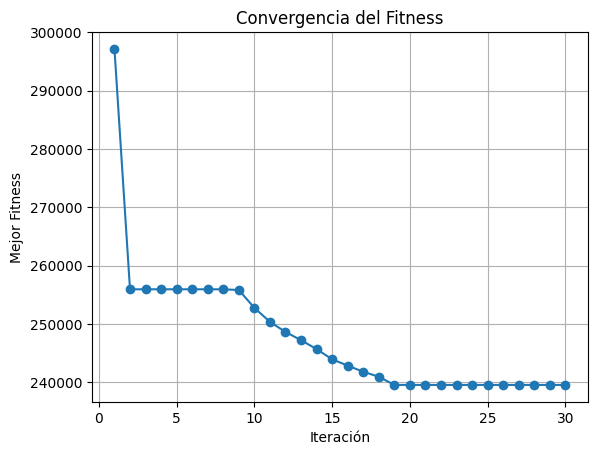

In [111]:
# Gráfica de convergencia del fitness
plt.plot(range(1, n_iterations + 1), best_fitness_values, marker='o')
plt.xlabel("Iteración")
plt.ylabel("Mejor Fitness")
plt.title("Convergencia del Fitness")
plt.grid(True)
plt.show()


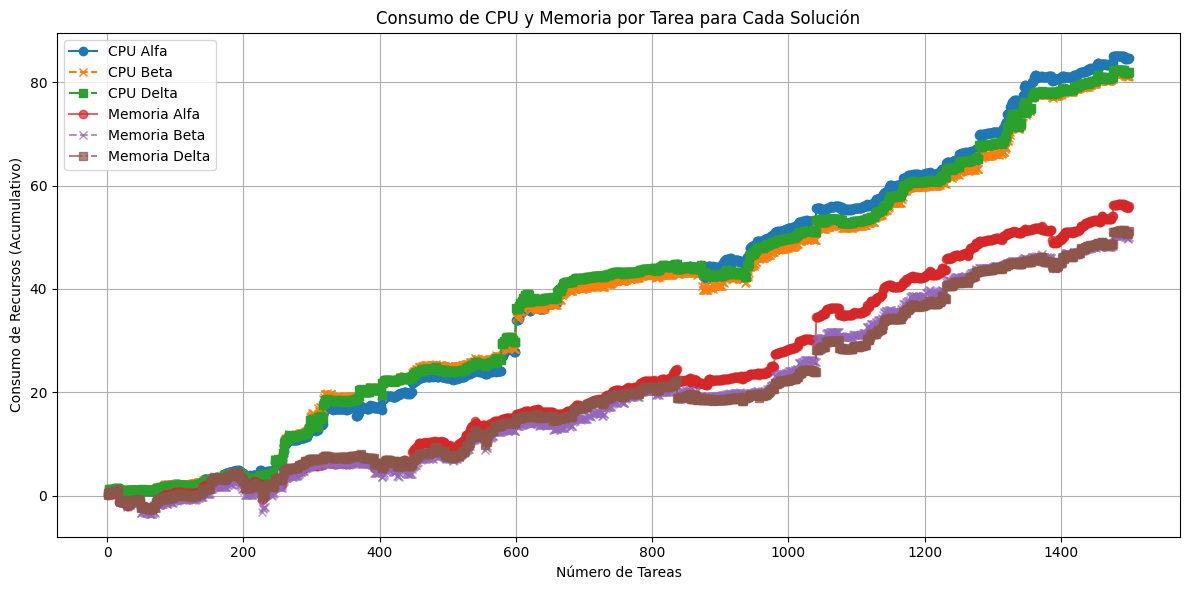

In [112]:
import matplotlib.pyplot as plt

# Definir los datos para el gráfico
n_tareas = np.arange(1, n_tasks + 1)

# Consumo de CPU y memoria acumulativo para cada solución
cpu_alfa = np.cumsum(alpha_pos * batch_task['cpus_requested'].values)
memoria_alfa = np.cumsum(alpha_pos * batch_task['memory_requested'].values)

cpu_beta = np.cumsum(beta_pos * batch_task['cpus_requested'].values)
memoria_beta = np.cumsum(beta_pos * batch_task['memory_requested'].values)

cpu_delta = np.cumsum(delta_pos * batch_task['cpus_requested'].values)
memoria_delta = np.cumsum(delta_pos * batch_task['memory_requested'].values)

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))

# Gráfico de Consumo de CPU
plt.plot(n_tareas, cpu_alfa, label='CPU Alfa', linestyle='-', marker='o')
plt.plot(n_tareas, cpu_beta, label='CPU Beta', linestyle='--', marker='x')
plt.plot(n_tareas, cpu_delta, label='CPU Delta', linestyle='-.', marker='s')

# Gráfico de Consumo de Memoria
plt.plot(n_tareas, memoria_alfa, label='Memoria Alfa', linestyle='-', marker='o', alpha=0.7)
plt.plot(n_tareas, memoria_beta, label='Memoria Beta', linestyle='--', marker='x', alpha=0.7)
plt.plot(n_tareas, memoria_delta, label='Memoria Delta', linestyle='-.', marker='s', alpha=0.7)

# Títulos y etiquetas
plt.title('Consumo de CPU y Memoria por Tarea para Cada Solución')
plt.xlabel('Número de Tareas')
plt.ylabel('Consumo de Recursos (Acumulativo)')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


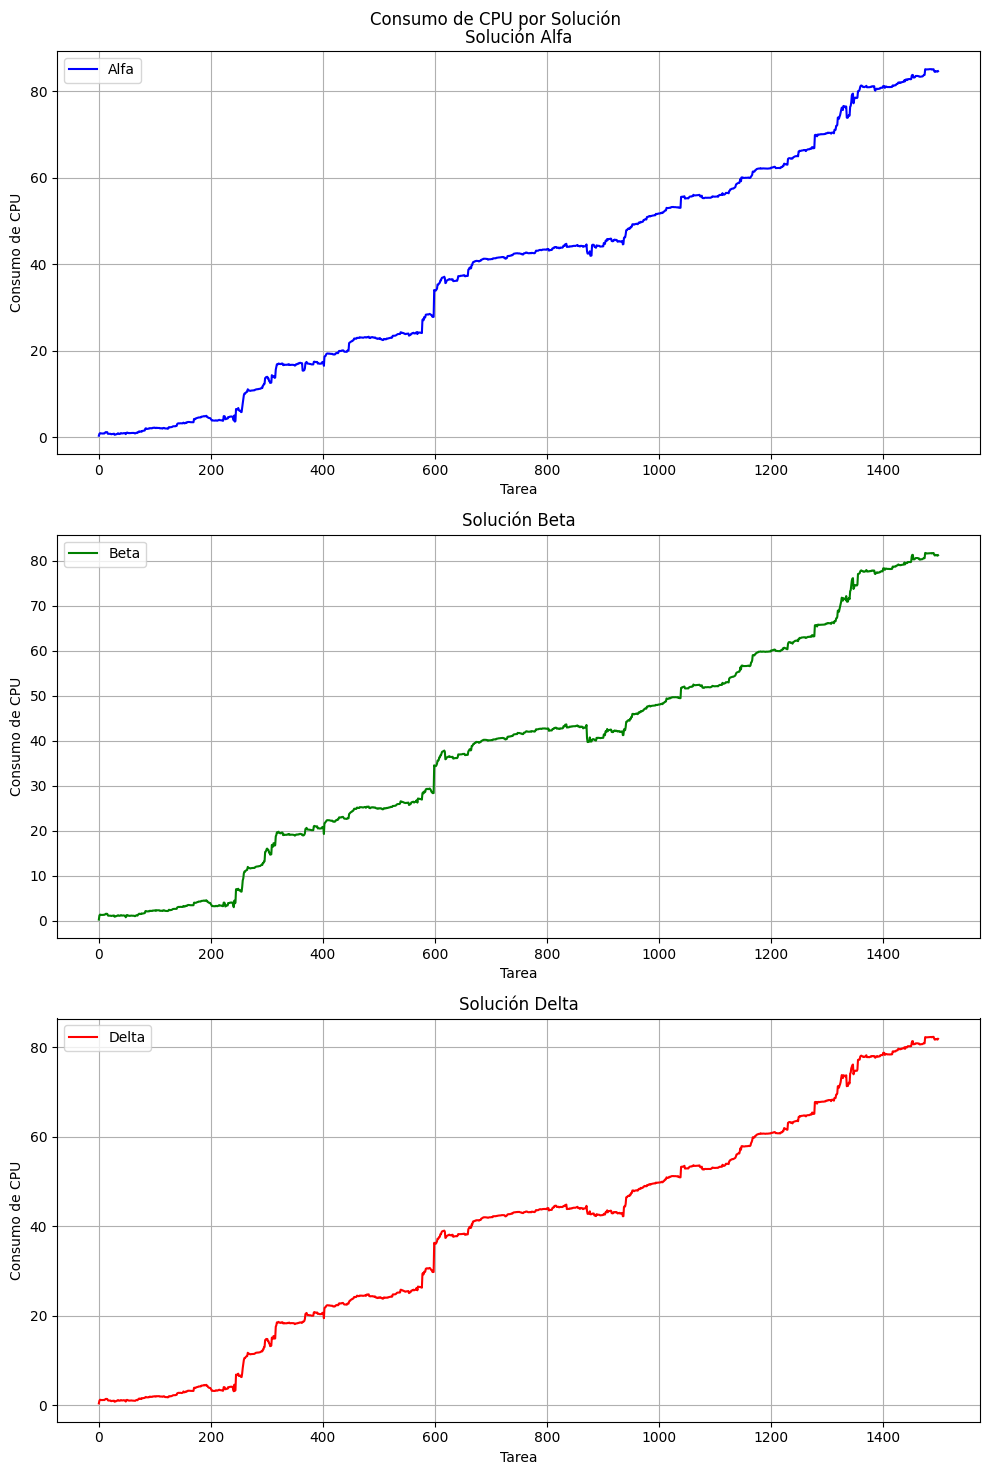

In [114]:
# Crear subplots para las 3 gráficas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Consumo de CPU por Solución')

# Gráfica para la solución Alfa
axs[0].plot(range(n_tasks), cpu_alfa, label='Alfa', color='blue')
axs[0].set_title('Solución Alfa')
axs[0].set_xlabel('Tarea')
axs[0].set_ylabel('Consumo de CPU')
axs[0].legend()
axs[0].grid(True)

# Gráfica para la solución Beta
axs[1].plot(range(n_tasks), cpu_beta, label='Beta', color='green')
axs[1].set_title('Solución Beta')
axs[1].set_xlabel('Tarea')
axs[1].set_ylabel('Consumo de CPU')
axs[1].legend()
axs[1].grid(True)

# Gráfica para la solución Delta
axs[2].plot(range(n_tasks), cpu_delta, label='Delta', color='red')
axs[2].set_title('Solución Delta')
axs[2].set_xlabel('Tarea')
axs[2].set_ylabel('Consumo de CPU')
axs[2].legend()
axs[2].grid(True)

# Ajustar el espacio entre las gráficas
plt.tight_layout()
plt.show()

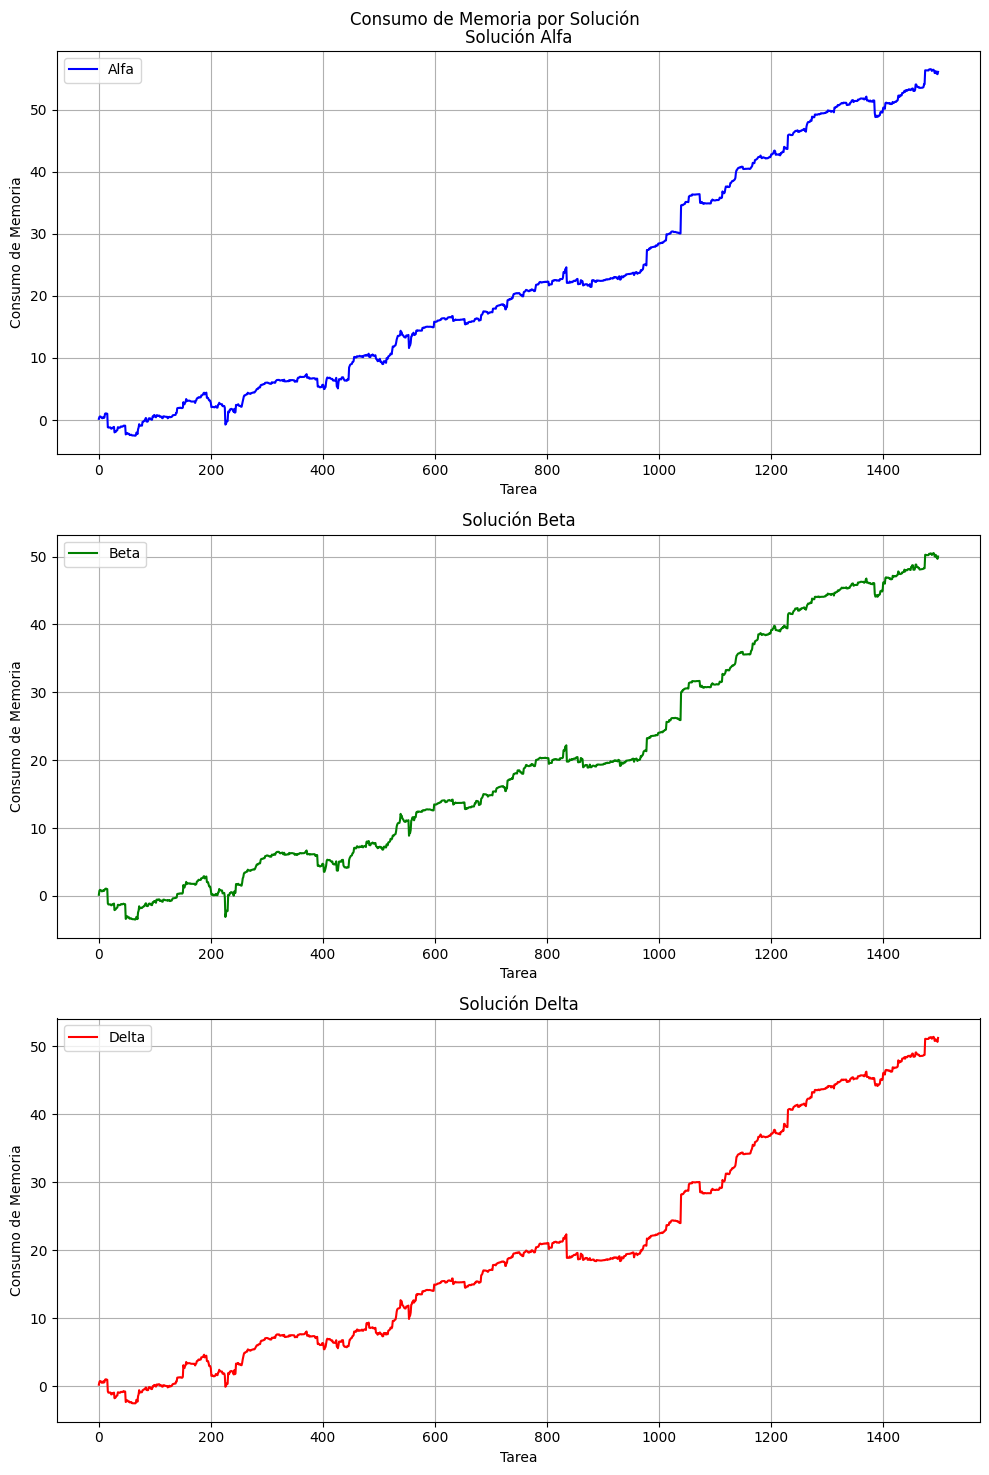

In [115]:
# Crear subplots para las 3 gráficas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Consumo de Memoria por Solución')

# Gráfica para la solución Alfa
axs[0].plot(range(n_tasks), memoria_alfa, label='Alfa', color='blue')
axs[0].set_title('Solución Alfa')
axs[0].set_xlabel('Tarea')
axs[0].set_ylabel('Consumo de Memoria')
axs[0].legend()
axs[0].grid(True)

# Gráfica para la solución Beta
axs[1].plot(range(n_tasks), memoria_beta, label='Beta', color='green')
axs[1].set_title('Solución Beta')
axs[1].set_xlabel('Tarea')
axs[1].set_ylabel('Consumo de Memoria')
axs[1].legend()
axs[1].grid(True)

# Gráfica para la solución Delta
axs[2].plot(range(n_tasks), memoria_delta, label='Delta', color='red')
axs[2].set_title('Solución Delta')
axs[2].set_xlabel('Tarea')
axs[2].set_ylabel('Consumo de Memoria')
axs[2].legend()
axs[2].grid(True)

# Ajustar el espacio entre las gráficas
plt.tight_layout()
plt.show()

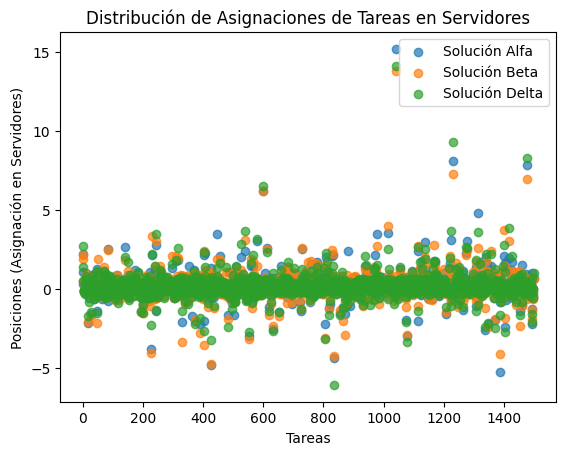

In [117]:
# Generando datos ejemplo para visualización.
plt.scatter(range(n_tasks), alpha_pos, label="Solución Alfa", alpha=0.7)
plt.scatter(range(n_tasks), beta_pos, label="Solución Beta", alpha=0.7)
plt.scatter(range(n_tasks), delta_pos, label="Solución Delta", alpha=0.7)
plt.xlabel("Tareas")
plt.ylabel("Posiciones (Asignación en Servidores)")
plt.title("Distribución de Asignaciones de Tareas en Servidores")
plt.legend()
plt.show()
